In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/video-coding-utils
!git clone https://github.com/pedrorohde/video-coding-utils.git
%cd video-coding-utils/
!ls

/content/drive/My Drive/video-coding-utils
fatal: destination path 'video-coding-utils' already exists and is not an empty directory.
/content/drive/My Drive/video-coding-utils/video-coding-utils
AR-CNN-test.ipynb  __pycache__	     utils.py	       YUV_H264_YUV.sh
__init__.py	   requirements.yml  utils_test.ipynb  yuv_test.ipynb


In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MSE

# get kernel sizes from original Matlab implementation of AR-CNN
import scipy.io
mat = scipy.io.loadmat('../../papers/AR-CNN test code/code/model/q40.mat')

---
## Architecture definition
Example architecture based on ARCNN

In [26]:
ARCNN = Sequential([
    Conv2D(64, 9, activation='relu', padding='same', input_shape=(64,64,1), name='conv1'), # 64 9x9 filters, ReLU activation
    Conv2D(32, 7, activation='relu', padding='same', name='conv2'),                        # 32 7x7 filters, ReLU activation
    Conv2D(16, 1, activation='relu', padding='same', name='conv3'),                        # 16 1x1 filters, ReLU activation
    Conv2D(1, 5, activation=None, padding='same', name='conv4'),                           # 1  5x5 filter,    no activation
], name='AR-CNN')

# originally "replicate" padding

In [27]:
ARCNN.summary()

Model: "AR-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 64)        5248      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        100384    
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 16)        528       
_________________________________________________________________
conv4 (Conv2D)               (None, 64, 64, 1)         401       
Total params: 106,561
Trainable params: 106,561
Non-trainable params: 0
_________________________________________________________________


---
## Creation of the training dataset

In [5]:
from utils import *

In [6]:
x_path = '../data/H264_raw/BasketballPass_416x240_50_H264_42.yuv'
y_path = '../data/YUV/BasketballPass_416x240_50.yuv'

In [7]:
height = int(y_path.split('_')[1].split('x')[1])
width = int(y_path.split('_')[1].split('x')[0])
size = (height, width)

In [8]:
X = read_YUV420_multiframes(x_path, size, range(0,256,2), channel='Y')
Y = read_YUV420_multiframes(y_path, size, range(0,256,2), channel='Y')

In [9]:
X.shape, Y.shape

((128, 240, 416), (128, 240, 416))

In [10]:
idxs = n_random_slices(1, range(128), size, (64,64))

In [11]:
X = patches_from_idxs(X, idxs)
Y = patches_from_idxs(Y, idxs)

In [12]:
X = X.reshape(*X.shape, 1)
Y = Y.reshape(*Y.shape, 1)

In [13]:
X.shape, Y.shape

((128, 64, 64, 1), (128, 64, 64, 1))

---
## Training

In [28]:
def PSNR(x,y):
    return tf.image.psnr(x,y,max_val=1)

ARCNN.compile(
    optimizer='SGD', # stochastic gradient descent (paper)
    loss=MSE, # mean squared error (paper)
    metrics=[PSNR]
)

Callback to save model weights at every epoch:

In [29]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/ARCNN',
    save_weights_only=True,
    monitor='val_loss',
    verbose=1
)

In [30]:
ARCNN.fit(
    X, Y,
    batch_size=16, # (paper=128)
    epochs=2, # guess
    callbacks=[ckpt_callback]
)

Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.1335 - PSNR: 10.1113
Epoch 00001: saving model to checkpoints/ARCNN
8/8 [==============================] - 4s 448ms/step - loss: 0.1335 - PSNR: 10.1113
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.0152 - PSNR: 18.2350
Epoch 00002: saving model to checkpoints/ARCNN
8/8 [==============================] - 4s 442ms/step - loss: 0.0152 - PSNR: 18.2350


---
# Testing

In [35]:
idx_test = n_random_slices(1, range(0,1), size, (64,64))

In [36]:
X_test = X[1:2,:,:,:]
Y_true = Y[1:2,:,:,:]

In [37]:
X_test = patches_from_idxs(read_YUV420_multiframes(x_path, size, range(0,1), channel='Y'), idx_test)
X_test = X_test.reshape(*X_test.shape, 1)

Y_true = patches_from_idxs(read_YUV420_multiframes(y_path, size, range(0,1), channel='Y'), idx_test)
Y_true = Y_true.reshape(*Y_true.shape, 1)

In [38]:
X_test.shape, Y_true.shape

((1, 64, 64, 1), (1, 64, 64, 1))

In [39]:
Y_pred = ARCNN.predict(X_test)

In [40]:
import matplotlib.pyplot as plt

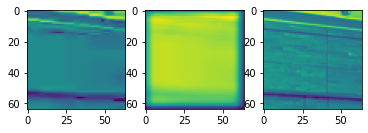

In [41]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(X_test[0,:,:,0])
ax[1].imshow(Y_pred[0,:,:,0])
ax[2].imshow(Y_true[0,:,:,0])
plt.show()

In [42]:
tf.reduce_sum(tf.keras.losses.mean_squared_error(Y_pred, Y_true))

<tf.Tensor: shape=(), dtype=float64, numpy=50.08385644798817>

In [43]:
tf.reduce_sum(tf.keras.losses.mean_squared_error(X_test, Y_true))

<tf.Tensor: shape=(), dtype=float64, numpy=2.5740561322568274>

---
## Loading saved weights

In [44]:
new_ARCNN = Sequential([
    Conv2D(64, 9, activation='relu', padding='same', input_shape=(64,64,1), name='conv1'), # 64 9x9 filters, ReLU activation
    Conv2D(32, 7, activation='relu', padding='same', name='conv2'),                        # 32 7x7 filters, ReLU activation
    Conv2D(16, 1, activation='relu', padding='same', name='conv3'),                        # 16 1x1 filters, ReLU activation
    Conv2D(1, 5, activation=None, padding='same', name='conv4'),                           # 1  5x5 filter,    no activation
], name='AR-CNN')

In [48]:
new_ARCNN.compile(
    optimizer='SGD', # stochastic gradient descent (paper)
    loss=MSE, # mean squared error (paper)
    metrics=[PSNR]
)
new_ARCNN.evaluate(X_test, Y_true)

1/1 [==============================] - 0s 1ms/step - loss: 0.2403 - PSNR: 6.1929


[0.24027809500694275, 6.19285774230957]

In [49]:
new_ARCNN.load_weights('checkpoints/ARCNN')
new_ARCNN.evaluate(X_test, Y_true)

1/1 [==============================] - 0s 989us/step - loss: 0.0122 - PSNR: 19.1266


[0.012227504514157772, 19.12662124633789]